# Exercise 5 [Direct Transcription Methods]

In [2]:
# a few packages we need to import

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython
import itertools

from scipy.linalg import block_diag

import cvxopt

In [3]:
def animate_car(x, goal):
    """
    This function makes an animation showing the behavior of the car
    takes as input the result of the solve_direct_transcription function 
    and the desired goal (x,y position)
    """
    
    #subsample
    plotx = x[:,:]
    
    fig = matplotlib.figure.Figure(figsize=[8,8])
    matplotlib.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-2,5.5], ylim=[-2,5.5])
    ax.grid()
    
    list_of_lines = []
    
    #create the cart pole
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'ob', lw=2)
    list_of_lines.append(line)
    
    car_length = 0.05
    car_height = 0.05
    
    def animate(i):
        for l in list_of_lines: #reset all lines
            l.set_data([],[])
        
        x_back = plotx[0,i] - car_length
        x_front = plotx[0,i] + car_length
        y_up = plotx[2,i] + car_height
        y_down = plotx[2,i] - car_height
        
        list_of_lines[0].set_data([x_back, x_front], [y_down, y_down])
        list_of_lines[1].set_data([x_front, x_front], [y_down, y_up])
        list_of_lines[2].set_data([x_back, x_front], [y_up, y_up])
        list_of_lines[3].set_data([x_back, x_back], [y_down, y_up])
        list_of_lines[4].set_data([goal[0],goal[0]],[goal[1],goal[1]])
        
        return list_of_lines
    
    def init():
        return animate(0)


    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:])),
        interval=100, blit=True, init_func=init)
    ani.save('./res/dtm.gif', writer='imagemagick')
#     plt.close(fig)
#     plt.close(ani._fig)
#     IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

# Using a quadratic program solver

In this exercise we will learn how to use a QP solver to solve LQ problems as in the model predictive control scheme presented in the class. Here we will use the quadratic program solver from cvxopt (https://cvxopt.org/). The installation instructions for the solver can be found here: https://cvxopt.org/install/index.html

A tutorial on how to use the QP solver can be found here: https://cvxopt.org/examples/tutorial/qp.html

And the function definition to use the QP solver can be found here: https://cvxopt.org/userguide/coneprog.html#quadratic-programming

As a first example, we see how a simple QP can be solved. Consider the following Quadratic Program
$$\min_x \frac{1}{2} x^T \begin{bmatrix} 1 & 0\\ 0 & 1 \end{bmatrix} x + \begin{bmatrix} -1 \\ -1 \end{bmatrix}^T x$$
subject to: $$ x_i > 0 \qquad \forall x_i$$
and
$$ \begin{bmatrix} 1 \\ 1 \end{bmatrix}^T x = 1$$

The first constraint just says that each element of $x$ needs to be positive and the second constraint says that the sum of the elements of $x$ needs to be equal to 1. Below is a way to use cvxopt to solve the problem.

In [52]:
# the qp solve of cvxopt accepts problems of the form 0.5 xT P x + qT x, subject to Gx <= h, Ax=b
# in our case we have
P = np.array([[1.,0],[0,1]]) # be careful to write 1. instead of 1 in Python 2.0
q = np.array([[-1.],[-1.]])
G = np.array([[-1.,0],[0,-1.]])
h = np.array([[0.],[0]])
A = np.array([[1.,1]])
b = np.array([[1.]])

# we need to convert numpy arrays into the matrix structures understood by cvxopt
# you could also construct directly matrix objects without passing through numpy 
# here we demonstrate how to go from numpy to cvxopt.matrix because we have used numpy arrays thus far
P = cvxopt.matrix(P)
q = cvxopt.matrix(q)
G = cvxopt.matrix(G)
h = cvxopt.matrix(h)
A = cvxopt.matrix(A)
b = cvxopt.matrix(b)

# now we can just solve the qp by calling the qp function from cvxopt
sol = cvxopt.solvers.qp(P, q, G, h, A, b)
# we convert the solution as a numpy array back
x = np.array(sol['x'])

print('The solution of the problem is x=')
print(x)

     pcost       dcost       gap    pres   dres
 0: -7.5000e-01 -1.7500e+00  1e+00  0e+00  2e+00
 1: -7.5000e-01 -7.6000e-01  1e-02  2e-16  2e-02
 2: -7.5000e-01 -7.5010e-01  1e-04  3e-16  1e-04
 3: -7.5000e-01 -7.5000e-01  1e-06  0e+00  2e-06
 4: -7.5000e-01 -7.5000e-01  1e-08  0e+00  2e-08
Optimal solution found.
The solution of the problem is x=
[[0.5]
 [0.5]]


If we wanted to solve the same problem without the constraint that the sum of the vector components should be equal to 1, we could do it simply by omiting the A and b inputs

In [53]:
# now we can just solve the qp by calling the qp function from cvxopt
sol = cvxopt.solvers.qp(P,q,G,h)
# we convert the solution as a numpy array back
x = np.array(sol['x'])

print('The solution of the problem is x=')
print(x)

     pcost       dcost       gap    pres   dres
 0: -7.5000e-01 -1.7500e+00  1e+00  0e+00  1e+00
 1: -9.4382e-01 -9.5908e-01  2e-02  2e-16  2e-01
 2: -1.0000e+00 -1.0018e+00  2e-03  0e+00  6e-17
 3: -1.0000e+00 -1.0000e+00  2e-05  0e+00  2e-17
 4: -1.0000e+00 -1.0000e+00  2e-07  3e-16  9e-17
Optimal solution found.
The solution of the problem is x=
[[1.00000009]
 [1.00000009]]


# Direct transcription for the car model

Consider a 2 dimensional car model
$$ x_{n+1} = \begin{bmatrix} 1 & \Delta t & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & \Delta t \\ 0 & 0 & 0 & 1 \end{bmatrix} x_n + \begin{bmatrix} 0 & 0\\ \Delta t & 0 \\ 0 & 0 \\ 0 & \Delta t \end{bmatrix} u_n$$

where the first element of $x_n$ is the car horizontal position, the second element is the horizontal velocity, the third element the vertical position and the last element the vertical velocity. $u_n$ contains the horizontal and vertical acceleration as control inputs.

We would like to get the car from initial position (0,0) to the final goal (5,2) with 0 desired final velocities under the constraints that the maximum acceleration is limited to 5 in each direction. Here we will use $\Delta t = 0.1$ and an horizon length of 100 steps.

## Question 1
Write an optimal control problem (i.e. with a cost and constraints) that could find the desired behavior for the car  (you may encode the desired goal in the cost function).

## Answer for Question 1

Define the final desired state as:
$$
x^* = 
\begin{bmatrix}
    5 \\
    0 \\
    2 \\
    0
\end{bmatrix}
$$

Also define the matrices in the system dynamic as:
$$
A = \begin{bmatrix} 1 & \Delta t & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & \Delta t \\ 0 & 0 & 0 & 1 \end{bmatrix} 
\quad
B = \begin{bmatrix} 0 & 0\\ \Delta t & 0 \\ 0 & 0 \\ 0 & \Delta t \end{bmatrix}
$$

And define the optimal problem as:
$$
\min_u {(x_N - x^*)}^T (x_N - x^*) + \sum_{n=0}^{N-1} ({(x_n - x^*)}^T (x_n - x^*) + u_n^T u_n)
$$

In order to rewrite this problem as a QP problem, we need also define:
$$
\tilde{B}_n = 
\begin{bmatrix}
    A^{n-1} B & A^{n-2} B & \cdots & AB & B & 0 & \cdots & 0
\end{bmatrix}
$$

$$
\tilde{u}_n = 
\begin{bmatrix}
    u_0 \\
    u_1 \\
    \vdots \\
    u_{N-1}
\end{bmatrix}
$$

Then,
$$
x_n = A^n x_0 + \tilde{B}_n \tilde{u}
$$

$$
x_n - x^* = A^n x_0 + \tilde{B}_n \tilde{u}
$$


So the original optimization problem is now equivalent to:
$$
\min_{\tilde{u}}
{\tilde{u}}^T 
\Bigg(
    \sum_{n=0}^N {\tilde{B}}^T Q_n \tilde{B} + 
    \begin{bmatrix}
        R_0 & & & 0 \\
        & R_1 & & \\
        & & \ddots & \\
        0 & & & R_{N-1}
\end{bmatrix}
\Bigg) 
{\tilde{u}}
+ 2(\sum_{n=0}^N {(A^n x_0 + x^*)}^T Q_n \tilde{B}_n) \tilde{u}
$$ 


$$
s.t. \quad
\begin{bmatrix}
    -5 \\
    -5 \\
    \vdots \\
    -5
\end{bmatrix}
\leq
\tilde{u}
\leq
\begin{bmatrix}
    5 \\
    5 \\
    \vdots \\
    5
\end{bmatrix}
$$

## Question 2
We would like to solve the problem using the transcription method shown in the class. 
1. Write a function that finds a  solution to the problem (i.e. a control trajectory and the associated car states).
2. Find weights in your cost function such that the behavior resembles a  bang-bang controller (i.e. minimum time). Plot the resulting control input and state trajectory and use the animation function below to make a movie of the behavior
3. Find weights that reduce the bang bang behavior smoother. As before, plot states and controls and show an animation

## Answer for Question 2
### 2.1. Write a function that finds a solution to the problem.
First, we rewrite the optimization:

$$
\min_{\tilde{u}, \tilde{x}} 
{(\tilde{x} - \bar{x})}^T
\begin{bmatrix}
    Q_1 & & & 0 \\
    & Q_2 & & \\
    & & \ddots & \\
    0 & & & Q_N
\end{bmatrix}
(\tilde{x} - \bar{x})
+
{\tilde{u}}^T
\begin{bmatrix}
    R_0 & & & 0 \\
    & R_1 & & \\
    & & \ddots & \\
    0 & & & Q_{N-1} 
\end{bmatrix}
\tilde{u}
$$

$$
s.t. \quad
x_0 = x_{init}, \quad
x_{n+1} = A x_n + B u_n, \quad
\begin{bmatrix}
    \tilde{u} \\
    -\tilde{u}
\end{bmatrix}
\leq
\begin{bmatrix}
    5 \\
    5 \\
    \vdots \\
    5
\end{bmatrix}
$$

where 
$$
\tilde{x} =
\begin{bmatrix}
    x_1 \\
    x_2 \\
    \vdots \\
    x_N
\end{bmatrix}
\quad
\bar{x} = 
\begin{bmatrix}
    x^* \\
    x^* \\
    \vdots \\
    x^*
\end{bmatrix}
$$

Then reconstruct the optimization problem with direct transcription approach:
$$
\min_{\tilde{x}, \tilde{u}}
\frac{1}{2}
{\begin{bmatrix}
    \tilde{x} \\
    \tilde{u}
\end{bmatrix}}^T
\begin{bmatrix}
    Q_1 & & & & & & &  \\
    & Q_2 & & & & & &  \\
    & & \ddots & & & & &  \\
    & & & Q_N & & & &  \\
    & & & & R_0 & & &  \\
    & & & & & R_1 & &  \\
    & & & & & & \ddots &  \\
    & & & & & & & R_{N-1}
\end{bmatrix}
\begin{bmatrix}
    \tilde{x} \\
    \tilde{u}
\end{bmatrix}
-
{\begin{bmatrix}
    \bar{x} \\
    0 \\
    \vdots \\
    0
\end{bmatrix}}^T
\begin{bmatrix}
    Q_1 & & & & & & &  \\
    & Q_2 & & & & & &  \\
    & & \ddots & & & & &  \\
    & & & Q_N & & & &  \\
    & & & & 0 & & &  \\
    & & & & & 0 & &  \\
    & & & & & & \ddots &  \\
    & & & & & & & 0
\end{bmatrix}
\begin{bmatrix}
    \tilde{x} \\
    \tilde{u}
\end{bmatrix}
$$

$$
s.t. \quad
\begin{bmatrix}
    -I & 0 & \cdots & 0 & B & 0 & \cdots & 0 \\
    A & -I & \cdots & 0 & 0 & B & \cdots & 0 \\
    0 & A & \cdots & 0 & 0 & 0 & \cdots & 0 \\
    \vdots & \vdots &  & \vdots & \vdots & \vdots &  & \vdots \\
    0 & 0 & \cdots & -I & 0 & 0 & \cdots & B \\
\end{bmatrix}
\begin{bmatrix}
    \tilde{x} \\
    \tilde{u}
\end{bmatrix}
=
\begin{bmatrix}
    -A x_0 \\
    0 \\
    \vdots \\
    0
\end{bmatrix}
,
\quad
\quad
\begin{bmatrix}
    0 & 0 & \cdots & 0 & 1 & 0 & \cdots & 0  \\
    0 & 0 & \cdots & 0 & 0 & 1 & \cdots & 0  \\
    \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \ddots & \vdots  \\
    0 & 0 & \cdots & 0 & 0 & 0 & \cdots & 1  \\
    0 & 0 & \cdots & 0 & -1 & 0 & \cdots & 0  \\
    0 & 0 & \cdots & 0 & 0 & -1 & \cdots & 0  \\
    \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \ddots & \vdots  \\
    0 & 0 & \cdots & 0 & 0 & 0 & \cdots & -1
\end{bmatrix}
\begin{bmatrix}
    \tilde{x} \\
    \tilde{u}
\end{bmatrix}
\leq
\begin{bmatrix}
    5 \\
    5 \\
    \vdots \\
    5
\end{bmatrix}
$$

Plug in general form QP problem:
$$
\min_x \quad
\frac{1}{2} x^T P x + q^T x
$$

$$
s.t. \quad Gx \leq h, \quad
Cx = b
$$

Our $x \in \mathbb{R}^{600 \times 1}$, $P \in \mathbb{R}^{600 \times 600}$, $q \in \mathbb{R}^{1 \times 600}$, $G \in \mathbb{R}^{400 \times 600}$, $h \in \mathbb{R}^{400 \times 1}$, $C \in \mathbb{R}^{400 \times 600}$, $b \in \mathbb{R}^{400 \times 1}$ becomes:

$$
P=
\begin{bmatrix}
    Q_1 & & & & & & &  \\
    & Q_2 & & & & & &  \\
    & & \ddots & & & & &  \\
    & & & Q_N & & & &  \\
    & & & & R_0 & & &  \\
    & & & & & R_1 & &  \\
    & & & & & & \ddots &  \\
    & & & & & & & R_{N-1}
\end{bmatrix}
\quad
q =
{\begin{bmatrix}
    \bar{x} \\
    0 \\
    \vdots \\
    0
\end{bmatrix}}^T
\begin{bmatrix}
    Q_1 & & & & & & &  \\
    & Q_2 & & & & & &  \\
    & & \ddots & & & & &  \\
    & & & Q_N & & & &  \\
    & & & & 0 & & &  \\
    & & & & & 0 & &  \\
    & & & & & & \ddots &  \\
    & & & & & & & 0
\end{bmatrix}
$$

$$
G =
\begin{bmatrix}
    0 & 0 & \cdots & 0 & 1 & 0 & \cdots & 0  \\
    0 & 0 & \cdots & 0 & 0 & 1 & \cdots & 0  \\
    \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \ddots & \vdots  \\
    0 & 0 & \cdots & 0 & 0 & 0 & \cdots & 1  \\
    0 & 0 & \cdots & 0 & -1 & 0 & \cdots & 0  \\
    0 & 0 & \cdots & 0 & 0 & -1 & \cdots & 0  \\
    \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \ddots & \vdots  \\
    0 & 0 & \cdots & 0 & 0 & 0 & \cdots & -1
\end{bmatrix}
\quad
h = 
\begin{bmatrix}
    5 \\
    5 \\
    \vdots \\
    5
\end{bmatrix}
$$

$$
C =
\begin{bmatrix}
    -I & 0 & \cdots & 0 & B & 0 & \cdots & 0 \\
    A & -I & \cdots & 0 & 0 & B & \cdots & 0 \\
    0 & A & \cdots & 0 & 0 & 0 & \cdots & 0 \\
    \vdots & \vdots &  & \vdots & \vdots & \vdots &  & \vdots \\
    0 & 0 & \cdots & -I & 0 & 0 & \cdots & B \\
\end{bmatrix}
\quad
b =
\begin{bmatrix}
    -A x_0 \\
    0 \\
    \vdots \\
    0
\end{bmatrix}
$$

In [8]:
def solve_direct_transcription(A, B, Q, R, x0, horizon, u_max, x_des):
    """
    Here we want to find the optimal control path using a direct transcription approach
    
    Inputs: 
    A,B system dynamics
    Q,R: numpy arrays for the quadratic cost
    x_des: the desired goal position
    u_max: the maximum acceleration
    horizon_length: the number of steps
    
    returns: the state and control trajectories
    """    
    m, n = 4, 2                          # dimensions of x and u
    num_states = m * horizon             # the lenght of the state vector for the full trajectory is
    num_control = n * horizon            # the length of the control vector for the full trajectory is
    num_vars = num_states + num_control  # the total number of variables is

    # ---------------------------- #
    ## Construct P, q
    P = block_diag(*([Q] * horizon), *([R] * horizon))
    q = -1 * np.vstack([xN] * horizon + [np.array([[5], [0]])] * horizon)
    q = q.T @ block_diag(*([Q] * horizon), *([np.zeros((n, n))] * horizon))
    q = q.T

    ## Construct G, h
    # G = 
    # [
    #     G11 G12
    #     G21 G22
    # ]
    G11 = np.zeros((n * horizon, m * horizon))
    G12 = np.eye(n * horizon)
    G21 = np.zeros((n * horizon, m * horizon))
    G22 = -1 * np.eye(n * horizon)
    G = np.block([[G11, G12], [G21, G22]])
    h = np.vstack([u_max] * (horizon * m))

    ## Construct C, b
    # C = [C1 C2]
    C1 = block_diag(*([A] * (horizon - 1)))
    empty_row = np.zeros((m, m * (horizon - 1)))
    C1 = np.vstack([empty_row, C1])
    empty_col = np.zeros((m * horizon, m))
    C1 = np.hstack([C1, empty_col])
    for i in range(m * horizon):
        C1[i][i] = -1
    C2 = block_diag(*([B] * horizon))
    C = np.hstack([C1, C2])
    b = np.vstack([-A @ x0] + [np.zeros((4, 1))] * (horizon - 1))
    # ---------------------------- #
    
    P = cvxopt.matrix(P)
    q = cvxopt.matrix(q)
    G = cvxopt.matrix(G)
    h = cvxopt.matrix(h)
    C = cvxopt.matrix(C)
    b = cvxopt.matrix(b)
    
    # once the problem is constructed we can call the solver
    sol = cvxopt.solvers.qp(P, q, G, h, C, b)
    x = np.array(sol['x'])
    
    ## we assume that the problem was constructed with the states first (x0,x1,...)
    ## and then the control inputs (u0, u1, ...)
    u = (x[num_states:].reshape(horizon, 2)).transpose()
    x = x[0:num_states]
    x = np.vstack((x0.T, x.reshape([horizon, x0.size]))).transpose()

    return x, u
        

### 2.2. Find weights in your cost function such that the behavior resembles a bang-bang controller.
Plot the resulting control input and state trajectory and use the animation function below to make a movie of the behavior

Choose:
$$ 
R = 
\begin{bmatrix}
    0 & 0 \\
    0 & 0
\end{bmatrix}
\quad
Q = 
\begin{bmatrix}
    1 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 \\
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 0
\end{bmatrix}
$$

In this case, the cost function does not penalize the velocity and the acceleration. So the controller will take minimal time to reach the desired state.

In [55]:
dt = 0.1       # delta_t
A = np.array([
    [1, dt, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, dt],
    [0, 0, 0, 1]
])
B = np.array([
    [0, 0],
    [dt, 0],
    [0, 0],
    [0, dt]
])
Q = np.array([
    [1., 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 1., 0],
    [0, 0, 0, 0]
])
R = np.array([
    [0, 0],
    [0, 0]
])
x0 = np.array([[0], [0], [0], [0]])
xN = np.array([[5], [0], [2], [0]])

x, u = solve_direct_transcription(A, B, Q, R, x0, 100, 5., xN)

animate_car(x, np.array([5, 2]))

     pcost       dcost       gap    pres   dres
 0: -1.2668e+03 -9.8075e+03  9e+03  1e-13  3e-15
 1: -1.3086e+03 -1.8958e+03  6e+02  5e-14  1e-15
 2: -1.3358e+03 -1.3966e+03  6e+01  3e-14  7e-16
 3: -1.3426e+03 -1.3528e+03  1e+01  1e-14  3e-16
 4: -1.3438e+03 -1.3477e+03  4e+00  7e-15  2e-16
 5: -1.3442e+03 -1.3455e+03  1e+00  6e-15  2e-16
 6: -1.3444e+03 -1.3446e+03  1e-01  5e-15  1e-16
 7: -1.3445e+03 -1.3445e+03  1e-02  6e-15  2e-16
 8: -1.3445e+03 -1.3445e+03  8e-04  5e-15  1e-16
Optimal solution found.


#### State Trajectory:

Text(0.5, 0, 'Time')

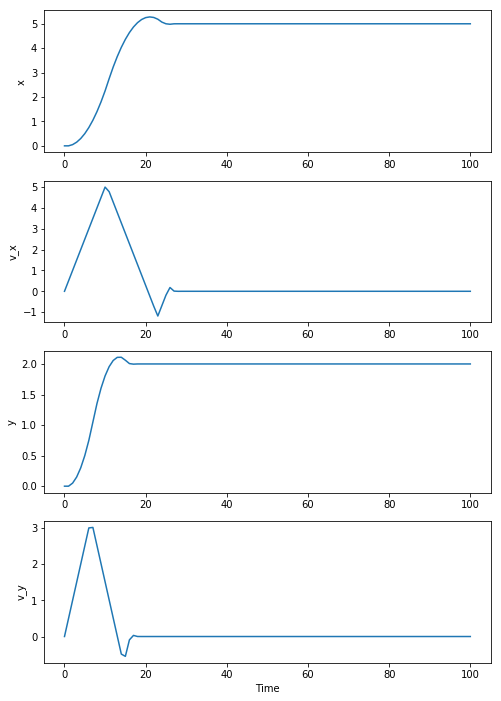

In [60]:
# plot x and theta as a function of time
plt.figure(figsize=(8, 12))
plt.subplot(4, 1, 1)
plt.plot(x[0,:])
plt.ylabel('x')

plt.subplot(4, 1, 2)
plt.plot(x[1,:])
plt.ylabel('v_x')

plt.subplot(4, 1, 3)
plt.plot(x[2,:])
plt.ylabel('y')

plt.subplot(4, 1, 4)
plt.plot(x[3,:])
plt.ylabel('v_y')
plt.xlabel('Time')

#### Control Input Trajectory

Text(0.5, 0, 'Time')

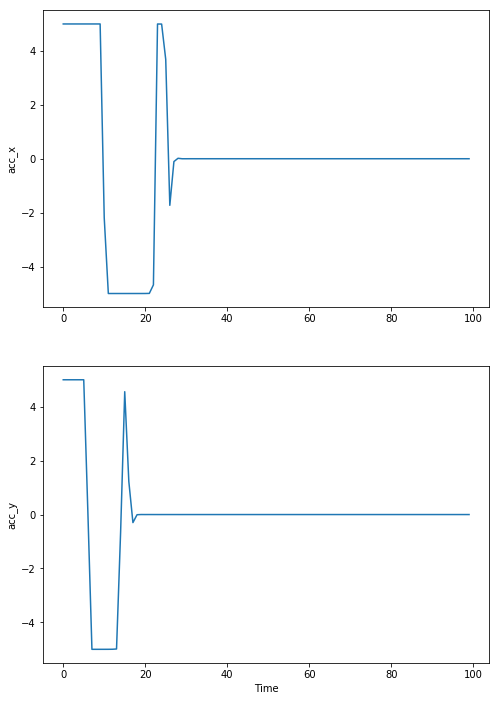

In [61]:
plt.figure(figsize=(8, 12))
plt.subplot(2, 1, 1)
plt.plot(u[0,:])
plt.ylabel('acc_x')

plt.subplot(2, 1, 2)
plt.plot(u[1,:])
plt.ylabel('acc_y')

plt.xlabel('Time')

### 2.3 Find weights that reduce the bang bang behavior smoother. As before, plot states and controls and show an animation
In this case, change the cost function by changing the matrices $Q$ and $R$ into:
$$ 
R = 
\begin{bmatrix}
    1 & 0 \\
    0 & 1
\end{bmatrix}
\quad
Q = 
\begin{bmatrix}
    1 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0 \\
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 1
\end{bmatrix}
$$

     pcost       dcost       gap    pres   dres
 0: -1.1830e+03 -8.5356e+03  7e+03  1e-13  3e-16
 1: -1.1971e+03 -1.4620e+03  3e+02  3e-14  4e-16
 2: -1.1985e+03 -1.2044e+03  6e+00  7e-15  3e-16
 3: -1.1985e+03 -1.1986e+03  1e-01  5e-15  3e-16
 4: -1.1985e+03 -1.1985e+03  2e-03  5e-15  3e-16
 5: -1.1985e+03 -1.1985e+03  2e-05  5e-15  3e-16
Optimal solution found.


Text(0.5, 0, 'Time')

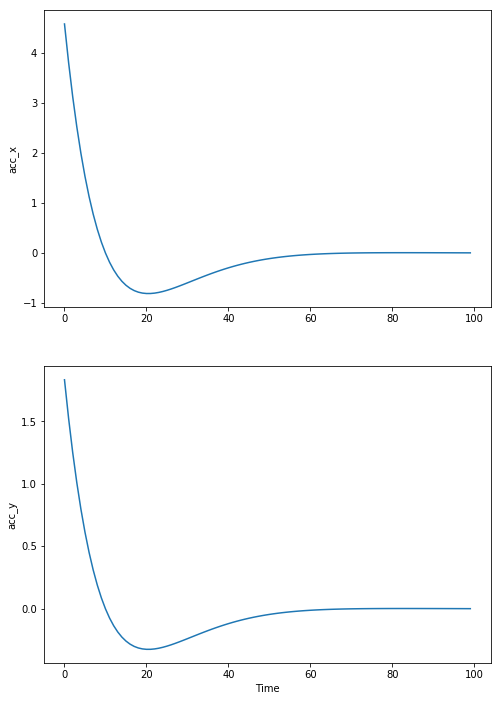

In [9]:
dt = 0.1       # delta_t
A = np.array([
    [1, dt, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, dt],
    [0, 0, 0, 1]
])
B = np.array([
    [0, 0],
    [dt, 0],
    [0, 0],
    [0, dt]
])
Q = np.array([
    [1., 0, 0, 0],
    [0, 1., 0, 0],
    [0, 0, 1., 0],
    [0, 0, 0, 1.]
])
R = np.array([
    [1., 0],
    [0, 1.]
])
x0 = np.array([[0], [0], [0], [0]])
xN = np.array([[5], [0], [2], [0]])

x, u = solve_direct_transcription(A, B, Q, R, x0, 100, 5., xN)

animate_car(x, np.array([5, 2]))

#### State trajectory

Text(0.5, 0, 'Time')

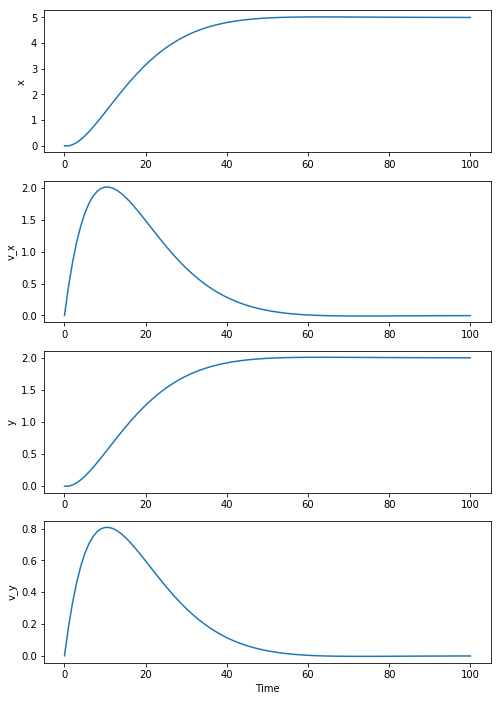

In [12]:
# plot x and theta as a function of time
plt.figure(figsize=(8, 12))
plt.subplot(4, 1, 1)
plt.plot(x[0,:])
plt.ylabel('x')

plt.subplot(4, 1, 2)
plt.plot(x[1,:])
plt.ylabel('v_x')

plt.subplot(4, 1, 3)
plt.plot(x[2,:])
plt.ylabel('y')

plt.subplot(4, 1, 4)
plt.plot(x[3,:])
plt.ylabel('v_y')
plt.xlabel('Time')

#### Control input trajectory

Text(0.5, 0, 'Time')

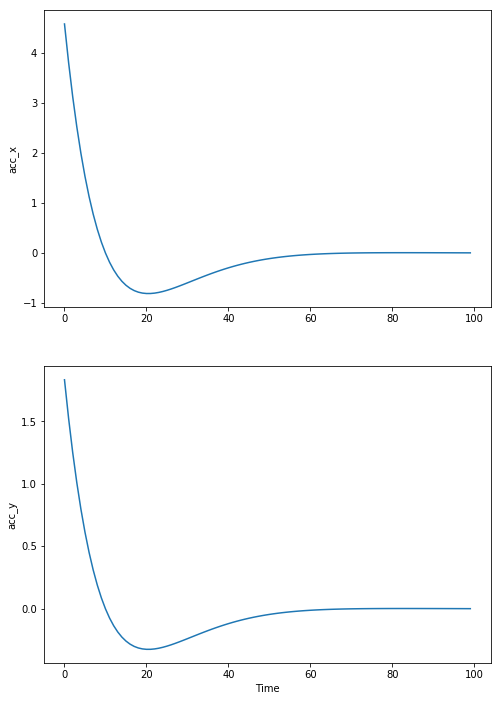

In [11]:
plt.figure(figsize=(8, 12))
plt.subplot(2, 1, 1)
plt.plot(u[0,:])
plt.ylabel('acc_x')

plt.subplot(2, 1, 2)
plt.plot(u[1,:])
plt.ylabel('acc_y')

plt.xlabel('Time')

***

## Question 3
Now assume that we add an additional constraint saying that at all times, the sum of the horizontal and vertical velocities of the car cannot be greated than 1. 
1. Write the new optimal control problem.
2. Write a novel function that solves this new problem.
3. How do the trajectories change compared to the case without the constraint? Analyze the resulting behavior, could you have found it manually? (as before, plot trajectories and show an animation)

## Answer for Question 3

### 3.1 Rewrite the new optimal control problem.
Use notation $E$ to represent the following martix:
$$
E =
\begin{bmatrix}
    0 & 1 & 0 & 1 \\
    0 & -1 & 0 & 1 \\
    0 & 1 & 0 & -1 \\
    0 & -1 & 0 & -1 \\
\end{bmatrix}
$$

Then, the new constraint for the sum of velocities can be written in matrix form as:
$$
G' \tilde{x}
\leq
\begin{bmatrix}
    1 \\
    1 \\
    \vdots \\
    1
\end{bmatrix}
$$

where
$$
G' \in \mathbb{R}^{4 N \times 4 N} \quad
G' =
\begin{bmatrix}
    E & 0 & 0 & \cdots & 0 \\
    0 & E & 0 & \cdots & 0 \\
    0 & 0 & E & \cdots & 0 \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & 0 & \cdots & E
\end{bmatrix}
$$

which is equivalent to:
$$
G'' 
\begin{bmatrix}
    \tilde{x} \\
    \tilde{u}
\end{bmatrix}
\leq
\begin{bmatrix}
    1 \\
    1 \\
    \vdots \\
    1
\end{bmatrix}
$$

where
$$
G'' \in \mathbb{R}^{4 N \times 6 N} \quad
G'' =
\begin{bmatrix}
    E & 0 & 0 & \cdots & 0 & 0 & \cdots & 0 \\
    0 & E & 0 & \cdots & 0 & 0 & \cdots & 0 \\
    0 & 0 & E & \cdots & 0 & 0 & \cdots & 0 \\
    \vdots & \vdots & \vdots & \cdots & \vdots & \vdots & \cdots & \vdots \\
    0 & 0 & 0 & \cdots & E & 0 & \cdots & 0
\end{bmatrix}
$$

The system dynamic and the cost function are not changed, while we need to add a new constraint to the original QP problem by modifying the $G$ matrix.

$$
\min_x \quad
\frac{1}{2} x^T P x + q^T x
$$

$$
s.t. \quad Gx \leq h, \quad
Cx = b
$$

where

$$
P=
\begin{bmatrix}
    Q_1 & & & & & & &  \\
    & Q_2 & & & & & &  \\
    & & \ddots & & & & &  \\
    & & & Q_N & & & &  \\
    & & & & R_0 & & &  \\
    & & & & & R_1 & &  \\
    & & & & & & \ddots &  \\
    & & & & & & & R_{N-1}
\end{bmatrix}
\quad
q =
{\begin{bmatrix}
    \bar{x} \\
    0 \\
    \vdots \\
    0
\end{bmatrix}}^T
\begin{bmatrix}
    Q_1 & & & & & & &  \\
    & Q_2 & & & & & &  \\
    & & \ddots & & & & &  \\
    & & & Q_N & & & &  \\
    & & & & 0 & & &  \\
    & & & & & 0 & &  \\
    & & & & & & \ddots &  \\
    & & & & & & & 0
\end{bmatrix}
$$

$$
G_{new} =
\begin{bmatrix}
    G'' \\
    G_{pre}
\end{bmatrix}
\quad
G_{pre} =
\begin{bmatrix}
    0 & 0 & \cdots & 0 & 1 & 0 & \cdots & 0  \\
    0 & 0 & \cdots & 0 & 0 & 1 & \cdots & 0  \\
    \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \ddots & \vdots  \\
    0 & 0 & \cdots & 0 & 0 & 0 & \cdots & 1  \\
    0 & 0 & \cdots & 0 & -1 & 0 & \cdots & 0  \\
    0 & 0 & \cdots & 0 & 0 & -1 & \cdots & 0  \\
    \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \ddots & \vdots  \\
    0 & 0 & \cdots & 0 & 0 & 0 & \cdots & -1
\end{bmatrix}
\quad
h_{new} = 
\begin{bmatrix}
    1 \\
    \vdots \\
    1 \\
    5 \\
    \vdots \\
    5
\end{bmatrix}
$$

$$
C =
\begin{bmatrix}
    -I & 0 & \cdots & 0 & B & 0 & \cdots & 0 \\
    A & -I & \cdots & 0 & 0 & B & \cdots & 0 \\
    0 & A & \cdots & 0 & 0 & 0 & \cdots & 0 \\
    \vdots & \vdots &  & \vdots & \vdots & \vdots &  & \vdots \\
    0 & 0 & \cdots & -I & 0 & 0 & \cdots & B \\
\end{bmatrix}
\quad
b =
\begin{bmatrix}
    -A x_0 \\
    0 \\
    \vdots \\
    0
\end{bmatrix}
$$

### 3.2 Write a novel function that solves this new problem
Construct the new $G$ in the novel function then use QP solver to optimize the problem.

In [15]:
def solve_direct_transcription_new(A, B, Q, R, x0, horizon, u_max, x_des):
    """
    Here we want to find the optimal control path using a direct transcription approach
    
    Inputs: 
    A,B system dynamics
    Q,R: numpy arrays for the quadratic cost
    x_des: the desired goal position
    u_max: the maximum acceleration
    horizon_length: the number of steps
    
    returns: the state and control trajectories
    """    
    m, n = 4, 2                          # dimensions of x and u
    num_states = m * horizon             # the lenght of the state vector for the full trajectory is
    num_control = n * horizon            # the length of the control vector for the full trajectory is
    num_vars = num_states + num_control  # the total number of variables is

    # ---------------------------- #
    ## Construct P, q
    P = block_diag(*([Q] * horizon), *([R] * horizon))
    q = -1 * np.vstack([xN] * horizon + [np.array([[5], [0]])] * horizon)
    q = q.T @ block_diag(*([Q] * horizon), *([np.zeros((n, n))] * horizon))
    q = q.T

    G11 = np.zeros((n * horizon, m * horizon))
    G12 = np.eye(n * horizon)
    G21 = np.zeros((n * horizon, m * horizon))
    G22 = -1 * np.eye(n * horizon)
    G = np.block([[G11, G12], [G21, G22]])
    E = np.array([
        [0, 1, 0, 1],
        [0, -1, 0, 1],
        [0, 1, 0, -1],
        [0, -1, 0, -1]
    ])
    G_add = block_diag(*([E] * horizon))
    G_add = np.hstack((G_add, np.zeros((4 * horizon, n * horizon))))
    G = np.vstack((G_add, G))
    h = np.vstack([u_max] * (horizon * m))
    h_add = np.vstack([1] * (horizon * 4))
    h = np.vstack((h_add, h))

    C1 = block_diag(*([A] * (horizon - 1)))
    empty_row = np.zeros((m, m * (horizon - 1)))
    C1 = np.vstack([empty_row, C1])
    empty_col = np.zeros((m * horizon, m))
    C1 = np.hstack([C1, empty_col])
    for i in range(m * horizon):
        C1[i][i] = -1
    C2 = block_diag(*([B] * horizon))
    C = np.hstack([C1, C2])
    b = np.vstack([-A @ x0] + [np.zeros((4, 1))] * (horizon - 1))
    # ---------------------------- #
    
    P = cvxopt.matrix(P)
    q = cvxopt.matrix(q)
    G = cvxopt.matrix(G)
    h = cvxopt.matrix(h)
    C = cvxopt.matrix(C)
    b = cvxopt.matrix(b)
    
    # once the problem is constructed we can call the solver
    sol = cvxopt.solvers.qp(P, q, G, h, C, b)
    x = np.array(sol['x'])
    
    ## we assume that the problem was constructed with the states first (x0,x1,...)
    ## and then the control inputs (u0, u1, ...)
    u = (x[num_states:].reshape(horizon, 2)).transpose()
    x = x[0:num_states]
    x = np.vstack((x0.T, x.reshape([horizon, x0.size]))).transpose()

    return x, u

In [16]:
dt = 0.1       # delta_t
A = np.array([
    [1, dt, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, dt],
    [0, 0, 0, 1]
])
B = np.array([
    [0, 0],
    [dt, 0],
    [0, 0],
    [0, dt]
])
Q = np.array([
    [1., 0, 0, 0],
    [0, 1., 0, 0],
    [0, 0, 1., 0],
    [0, 0, 0, 1.]
])
R = np.array([
    [1., 0],
    [0, 1.]
])
x0 = np.array([[0], [0], [0], [0]])
xN = np.array([[5], [0], [2], [0]])

x, u = solve_direct_transcription_new(A, B, Q, R, x0, 100, 5., xN)

animate_car(x, np.array([5, 2]))

     pcost       dcost       gap    pres   dres
 0: -1.1559e+03 -1.1268e+04  2e+04  5e-01  4e-16
 1: -1.0592e+03 -3.9970e+03  3e+03  5e-02  1e-15
 2: -1.0643e+03 -1.2568e+03  2e+02  2e-03  2e-15
 3: -1.0804e+03 -1.0938e+03  1e+01  1e-04  2e-15
 4: -1.0832e+03 -1.0839e+03  7e-01  3e-06  7e-15
 5: -1.0835e+03 -1.0835e+03  5e-02  1e-07  5e-14
 6: -1.0835e+03 -1.0835e+03  6e-03  1e-08  1e-13
 7: -1.0835e+03 -1.0835e+03  4e-04  5e-10  2e-13
Optimal solution found.


#### State Trajectory

Text(0.5, 0, 'Time')

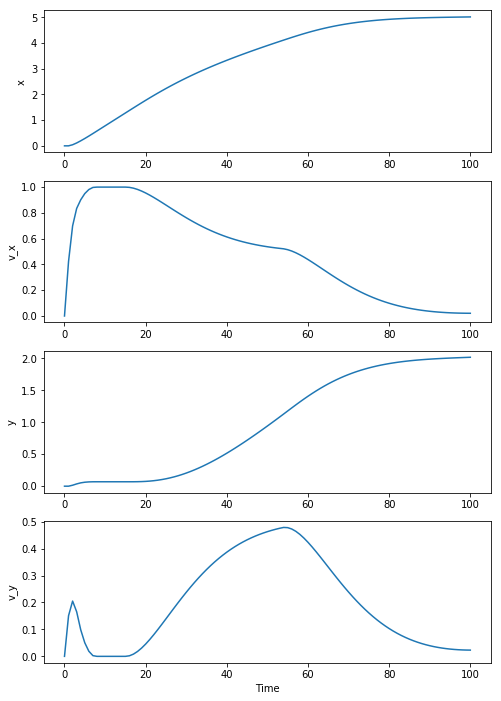

In [17]:
# plot x and theta as a function of time
plt.figure(figsize=(8, 12))
plt.subplot(4, 1, 1)
plt.plot(x[0,:])
plt.ylabel('x')

plt.subplot(4, 1, 2)
plt.plot(x[1,:])
plt.ylabel('v_x')

plt.subplot(4, 1, 3)
plt.plot(x[2,:])
plt.ylabel('y')

plt.subplot(4, 1, 4)
plt.plot(x[3,:])
plt.ylabel('v_y')
plt.xlabel('Time')

#### Control Input Trajectory

Text(0.5, 0, 'Time')

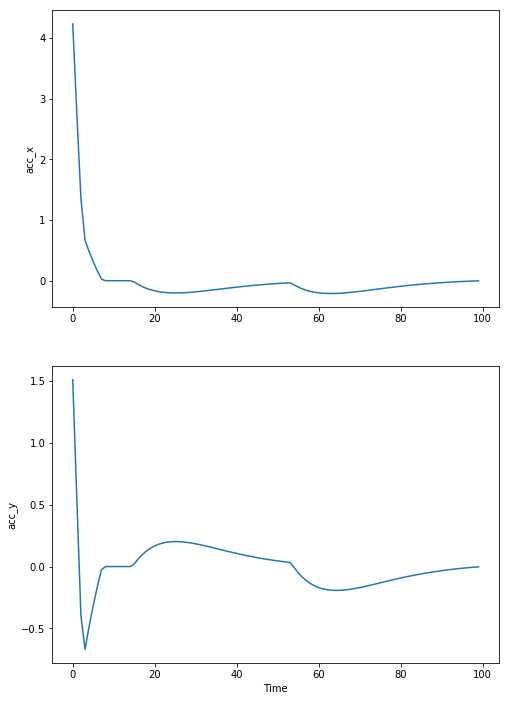

In [18]:
plt.figure(figsize=(8, 12))
plt.subplot(2, 1, 1)
plt.plot(u[0,:])
plt.ylabel('acc_x')

plt.subplot(2, 1, 2)
plt.plot(u[1,:])
plt.ylabel('acc_y')

plt.xlabel('Time')

### 3.3 How do the trajectories change compared to the case without the constraint?
Analyze the resulting behavior, could you have found it manually? (as before, plot trajectories and show an animation)

1. Compared to the case without the constraint on speed, the car takes longer time to reach the desired state.
2. At the begining of, the controller may sacrifice the vertical speed as its horizonal state has bigger difference with the desired state.

And yes, we can find the controller manually: the controller will first only use horizonal acceleration to let the car reach the point $(3, 0)$, where the vertical difference and horizonal difference between current state and the desired state are the same. Then, the controller will set the same speed for both 2 direction to let the car get to the destination.